In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=22bd9436cce64d5af3b24b1ea8e1b9e33417e370e282341917a3c9df5e837672
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [2]:
import os
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image, ImageFile
import random
import json
import math
import sys
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, TensorDataset, DataLoader, SubsetRandomSampler, Subset
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet

## Parameters

In [3]:
USE_COLAB = True

if USE_COLAB:
    from google.colab import drive 
    drive.mount('/content/drive')
    HOMEDIR = '/content/drive/MyDrive/Study/MSBA/CS5242 Neural Networks and Deep Learning/Group Project'
else:
    HOMEDIR = 'D:\Google Drive\Study\MSBA\CS5242 Neural Networks and Deep Learning\Group Project'
    
os.chdir(HOMEDIR)


# File paths
TRAINDIR = os.path.join(HOMEDIR, 'train/train')
TESTDIR = os.path.join(HOMEDIR, 'test/test')
TRAIN_ANNOTATION = 'training_annotation.json'
OBJECTS_DICT = 'object1_object2.json'
RELATIONSHIP_DICT = 'relationship.json'
TRAIN_LOADER_ANNOTATION_FILENAME = 'train_annotation.txt'
TEST_LOADER_ANNOTATION_FILENAME = 'test_annotation.txt'
OUTPUT_FILENAME = 'output.csv'
CLASSIFIER_FILE = 'classifier_3.pkl'
ENCODER_FILE = 'encoder.pkl'
DECODER_FILE = 'decoder.pkl'

# Dataset parameters
END_FRAME = 30 # last frame number for all videos in the dataset
NUM_FRAMES = 8 # how many frames to take in each video

# Object classifier parameters
LOAD_CLASSIFIER = True # load saved model parameter?
TRAIN_CLASSIFIER = False
CLASSIFIER_EPOCHS = 15 # only used for training
EFFICIENTNET_VERSION = 'b5' # b0, b1, etc... depending on how much gpu ram is at your disposal
CLASSIFIER_WEIGHT_DECAY = 0.001
CLASSIFIER_USE_BEST = True # after training is complete, will load the weight when the validation score was best

# Encoder-decoder parameters
LOAD_RNN = False # load saved model parameter?
TRAIN_RNN = True
RNN_EPOCHS = 15 # only used for training
USE_GRU = True # otherwise LSTM
RNN_LAYERS = 1
RNN_BIDIRECTIONAL = False # we don't want to make the video symmetrical?
RNN_HIDDEN_SIZE = 256
EMBED_SIZE = 768 # dimensionality of image embeddings
RNN_WEIGHT_DECAY = 0.001
RNN_USE_BEST = True # after training is complete, will load the weight when the validation score was best

# Common parameters
BATCH_SIZE = 10
VALIDATION_SEED = 2021
VALIDATION_SPLIT = 0.05 # use small validation set as our training set is not big
RANDOM_SHIFT = True

Mounted at /content/drive


In [4]:
from video_dataset import VideoFrameDataset, ImglistToTensor

In [5]:
if torch.cuda.is_available():
    print("You have", torch.cuda.device_count(), "GPUs")
    device = torch.device("cuda:0") # if you have multiple gpu -> 1,2,...
    print("Running PyTorch on the GPU: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Running PyTorch on the CPU")

You have 1 GPUs
Running PyTorch on the GPU:  Tesla T4


## Read dictionaries

In [6]:
with open(os.path.join(HOMEDIR, TRAIN_ANNOTATION)) as reader:
    train_annotation = json.loads(reader.read())

with open(os.path.join(HOMEDIR, OBJECTS_DICT)) as reader:
    objects_dict = json.loads(reader.read())

with open(os.path.join(HOMEDIR, RELATIONSHIP_DICT)) as reader:
    relationship_dict = json.loads(reader.read())

#print(train_annotation)
#print(objects_dict)
#print(relationship_dict)

In [7]:
# Combine the object & relationship dictionaries
combined_dict = {}

# Add special start stop special chars
combined_dict['START'] = 0
combined_dict['END'] = 1

i = 2
for item in list(objects_dict.keys()) + list(relationship_dict.keys()):
    combined_dict[item] = i
    i += 1
    
# List of object/relationship classes in the combined dictionary
object_classes = [combined_dict[c] for c in objects_dict.keys()]
relationship_classes = [combined_dict[c] for c in relationship_dict.keys()]

#print(combined_dict)

In [8]:
# Then convert train_annotation indexes to the new one in combined_dict
inv_objects_dict = {v: k for k, v in objects_dict.items()}
inv_relationship_dict = {v: k for k, v in relationship_dict.items()}
inv_combined_dict = {v: k for k, v in combined_dict.items()}

new_train_annotation = {}
for ta in train_annotation.keys():
    values = train_annotation[ta]
    new_train_annotation[ta] = [combined_dict['START'], 
                                combined_dict[inv_objects_dict[values[0]]],
                                combined_dict[inv_relationship_dict[values[1]]],
                                combined_dict[inv_objects_dict[values[2]]],
                                combined_dict['END']]
    
#print(new_train_annotation)

## Data loader setup

In [9]:
def create_loader_annotation_file(is_train, start_frame, end_frame, max_videos=None):
    i = 0
    
    if is_train:
        filename = TRAIN_LOADER_ANNOTATION_FILENAME
        source_path = TRAINDIR
    else:
        filename = TEST_LOADER_ANNOTATION_FILENAME
        source_path = TESTDIR
    
    with open(filename, 'w') as writer:
        for dir in sorted([v for v in os.listdir(source_path) if re.match('\d{6}', v)]):
            if is_train:
                labels = ' '.join(map(lambda x: str(x), new_train_annotation[dir]))
            else:
                labels = ''
            
            writer.write(f'{dir} {start_frame} {end_frame} {labels}\n')
            i += 1
            if max_videos and i >= max_videos:
                break
            
    print(f'{i} videos loaded to annotation file for {"train" if is_train else "test"}')

train_length = len([v for v in os.listdir(TRAINDIR) if re.match('\d{6}', v)])
test_length = len([v for v in os.listdir(TESTDIR) if re.match('\d{6}', v)])
    
create_loader_annotation_file(True, 1, NUM_FRAMES, train_length)
create_loader_annotation_file(False, 1, NUM_FRAMES, test_length)

447 videos loaded to annotation file for train
119 videos loaded to annotation file for test


In [10]:
%%capture

# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
efficientnet_size_dict = {
    'b0':224,
    'b1':240,
    'b2':260,
    'b3':300,
    'b4':380,
    'b5':456,
    'b6':528,
    'b7':600
}

# Adding some image augmentation when training the classifier
classifier_preprocess = transforms.Compose([
    ImglistToTensor(),
    transforms.RandomRotation(15, expand=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
    transforms.RandomResizedCrop((int(efficientnet_size_dict[EFFICIENTNET_VERSION] / 1.77777777), efficientnet_size_dict[EFFICIENTNET_VERSION]), scale=(0.8, 1.0), ratio=(1, 1.77777777)),
    transforms.CenterCrop(efficientnet_size_dict[EFFICIENTNET_VERSION]), 
    #transforms.Resize((int(efficientnet_size_dict[EFFICIENTNET_VERSION] / 1.77777777), efficientnet_size_dict[EFFICIENTNET_VERSION])), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# No augmentation for the rnn unless we can do uniformly for all frames
rnn_preprocess = transforms.Compose([
    ImglistToTensor(),
    transforms.Resize((int(efficientnet_size_dict[EFFICIENTNET_VERSION] / 1.77777777), efficientnet_size_dict[EFFICIENTNET_VERSION])), 
    transforms.CenterCrop(efficientnet_size_dict[EFFICIENTNET_VERSION]), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initiate train dataset (classifier)
classifier_train_dataset = VideoFrameDataset(
    root_path=TRAINDIR,
    annotationfile_path=os.path.join(HOMEDIR, TRAIN_LOADER_ANNOTATION_FILENAME),
    num_segments=1,
    frames_per_segment=NUM_FRAMES,
    imagefile_template='{:06d}.jpg',
    transform=classifier_preprocess,
    random_shift=RANDOM_SHIFT,
    test_mode=False
)

# Initiate train dataset (rnn), the difference is only on the preprocessor
rnn_train_dataset = VideoFrameDataset(
    root_path=TRAINDIR,
    annotationfile_path=os.path.join(HOMEDIR, TRAIN_LOADER_ANNOTATION_FILENAME),
    num_segments=1,
    frames_per_segment=NUM_FRAMES,
    imagefile_template='{:06d}.jpg',
    transform=rnn_preprocess,
    random_shift=RANDOM_SHIFT,
    test_mode=False
)

# Create data indices for training and validation splits
dataset_size = len(rnn_train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
random_seed = VALIDATION_SEED
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Initiate test dataset
test_dataset = VideoFrameDataset(
    root_path=TESTDIR,
    annotationfile_path=os.path.join(HOMEDIR, TEST_LOADER_ANNOTATION_FILENAME),
    num_segments=1,
    frames_per_segment=NUM_FRAMES,
    imagefile_template='{:06d}.jpg',
    transform=rnn_preprocess,
    random_shift=False,
    test_mode=True
)

# Load dataset into the data loader (classifier)
classifier_data_loader = {
    'train': torch.utils.data.DataLoader(
                dataset=Subset(classifier_train_dataset, train_indices),
                batch_size=BATCH_SIZE,
                num_workers=1,
                pin_memory=True,
                shuffle=True),
    
    'valid': torch.utils.data.DataLoader(
                dataset=Subset(rnn_train_dataset, val_indices), # no need to random transforms the validation set
                batch_size=BATCH_SIZE,
                num_workers=1,
                pin_memory=True,
                shuffle=True),
}

# Load dataset into the data loader (rnn)
data_loader = {
    'train': torch.utils.data.DataLoader(
                dataset=Subset(rnn_train_dataset, train_indices),
                batch_size=BATCH_SIZE,
                num_workers=1,
                pin_memory=True, # if you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory
                shuffle=True),
    
    'valid': torch.utils.data.DataLoader(
                dataset=Subset(rnn_train_dataset, val_indices),
                batch_size=BATCH_SIZE,
                num_workers=1,
                pin_memory=True,
                shuffle=True),
    
    'test': torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=BATCH_SIZE,
                num_workers=2,
                pin_memory=True,
                shuffle=False),
}

In [11]:
print('Train dataset:', len(data_loader['train']) * BATCH_SIZE)
print('Valid dataset:', len(data_loader['valid']) * BATCH_SIZE)
print('Test dataset:', len(data_loader['test']) * BATCH_SIZE)
images, captions = next(iter(data_loader['train']))
print('Batch shape:', images.shape)
print('Captions:', captions[0:5])

Train dataset: 430
Valid dataset: 30
Test dataset: 120
Batch shape: torch.Size([10, 8, 3, 456, 456])
Captions: tensor([[  0,   9,  67,   9,   1],
        [  0,  19,  47,  14,   1],
        [  0,  36,  72,  36,   1],
        [  0,   7,  61,  32,   1],
        [  0,  31, 116,  31,   1]])


## Define model components

In [12]:
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
                
        # Load pretrained CNN with gradients frozen
        self.cnn = EfficientNet.from_pretrained(f'efficientnet-{EFFICIENTNET_VERSION}')
        self.cnn.eval()
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1) # consider this as part of efficientnet feature extractor
        
        # Do a single feature extract on dummy just to get the final features size
        with torch.no_grad():
            features = self.cnn.extract_features(torch.zeros((1,3,256,256)))
            features = self.avgpool(features)
        b,f,_,_ = features.shape
        features = features.reshape(b,f)
        self.features_size = features.size(1)
                
        
    def forward(self, images):
        # The cnn cannot handle 5-dimensional data, so reshape it to 4-dimensional first
        num_batches, num_frames, num_channels, x, y = images.shape
        images = images.view(num_batches * num_frames, num_channels, x, y)

        # Exctract features
        with torch.no_grad():
            features = self.cnn.extract_features(images)
            features = self.avgpool(features)
        b,f,_,_ = features.shape
        features = features.reshape(b,f)
                
        # Reshape the features to how it supposed to be
        features = features.view(num_batches, num_frames, -1)
            
        return features

In [13]:
class ObjectMultiLabelClassifier(nn.Module):
    def __init__(self, features_size, num_classes, frame_strategy='mean'):
        super(ObjectMultiLabelClassifier, self).__init__()
                
        self.fc = nn.Linear(features_size, num_classes)
        #self.fc1 = nn.Linear(features_size, 1024)
        #self.bn1 = nn.BatchNorm1d(1024, momentum=0.01)
        #self.relu = nn.ReLU()
        #self.fc2 = nn.Linear(1024, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.strategy = frame_strategy
        
    def forward(self, features):
        assert features.ndim == 3
        batch_size, num_frames, _ = features.shape
                
        # Classify each frame individually
        if self.strategy == 'individual':
            features = features.view(batch_size * num_frames, -1)
            outputs = self.sigmoid(self.fc(features))
            #outputs = self.fc1(features)
            #outputs = self.bn1(outputs)
            #outputs = self.relu(outputs)
            #outputs = self.fc2(outputs)
            #outputs = self.sigmoid(outputs)

            return outputs.view(batch_size, num_frames, -1)
        
        # Classify each frame individually and take the mean before passing it to sigmoid
        elif self.strategy == 'mean':
            features = features.view(batch_size * num_frames, -1)
            outputs = self.fc(features)
            outputs = torch.mean(outputs.view(batch_size, num_frames, -1), dim=1) # take the average over all frames
            outputs = self.sigmoid(outputs)
            outputs = torch.Tensor.repeat(outputs, repeats=(1, NUM_FRAMES)).view(batch_size, NUM_FRAMES, -1)
            
            return outputs
        
        # Classify only the middle frame
        elif self.strategy == 'middle':
            outputs = self.fc(features[:, num_frames//2, :])
            outputs = self.sigmoid(outputs)
            outputs = torch.Tensor.repeat(outputs, repeats=(1, NUM_FRAMES)).view(batch_size, NUM_FRAMES, -1)
            
            return outputs

In [14]:
class Encoder(nn.Module):
    def __init__(self, features_size, embed_size=EMBED_SIZE):
        super(Encoder, self).__init__()
                
        self.embed = nn.Linear(features_size, embed_size)
                
        
    def forward(self, features):
        return self.embed(features)

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, use_gru, embed_size, hidden_size, vocab_size, num_layers=1, bidirectional=False):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        
        if use_gru:
            self.rnn = nn.GRU(input_size = embed_size + vocab_size, 
                                hidden_size = hidden_size,
                                num_layers = num_layers, 
                                batch_first = True, 
                                bidirectional = bidirectional)
        else:
            self.rnn = nn.LSTM(input_size = embed_size + vocab_size, 
                                hidden_size = hidden_size,
                                num_layers = num_layers, 
                                batch_first = True, 
                                bidirectional = bidirectional)
        
        # Number of hidden size is multiplied by 2 if bidirectional
        self.linear = nn.Linear((2 if bidirectional else 1) * hidden_size, vocab_size)
    
    
    def forward(self, features, output_len=5):
        # Concatenate each frame
        embed = features[:,0,:].unsqueeze(1)
        for frame in range(1, features.size(1)):
            embed = torch.cat((features[:,frame,:].unsqueeze(1), embed), dim=1)
        
        # Add padding with the length of our output
        for i in range(0, output_len):
            embed = torch.cat((torch.zeros((features.size(0), self.embed_size + self.vocab_size)).unsqueeze(1).to(device), embed), dim=1)
        
        lstm_outputs, _ = self.rnn(embed)

        out = self.linear(lstm_outputs[:, -1*output_len:,:])
        return out

In [16]:
class F1_Loss(nn.Module):
    """Custom F1 loss function, based on https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354"""
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        
        tp = (y_true * y_pred).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        
        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
        
        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1 # we want to maximize f1, not minimizing it

## Helper functions for model evaluation

In [17]:
def convert_array_to_words(output):
    """Convert a single dimensional array from the neural net to words"""
    if output is None:
        return ''
    
    return ' '.join(list(map(lambda x: inv_combined_dict[x], filter(lambda x: x >= 2, output))))


def convert_words_to_numbers(words):
    """Convert words to numbers as defined in the json files"""
    if words is None:
        return ''
    
    splits = words.split(' ')
    codes = map(lambda c: str(c), map(lambda w: objects_dict[w] if w in objects_dict else relationship_dict[w], splits))
    
    return ' '.join(codes)


def get_predictions(images):
    """Predict videos from data loader by forwarding it through our model and return the outputs"""

    feature_extractor.eval()
    object_classifier.eval()
    encoder.eval()
    decoder.eval()

    images = images.to(device)        

    with torch.no_grad():
        features = feature_extractor(images)
        objects = object_classifier(features)
        embeddings = encoder(features)
        objects_and_embeddings = torch.cat((objects, embeddings), dim=2) 
        outputs = decoder(objects_and_embeddings)
    
    return outputs.cpu()


def get_top5_predictions_from_output_probabilities(outputs, index):
    """Get top 5 predictions as array"""
    top_n = torch.topk(outputs[index], k=len(combined_dict), dim=1).indices[1:4].numpy()
    
    # Get top 5 which are not START or END and included in the possible classes (object or relationship)
    result = []
    for i in range(top_n.shape[0]):
        possible_classes = object_classes if i == 0 or i == 2 else relationship_classes
        classes = list(filter(lambda j: j >= 2 and j in possible_classes, top_n[i]))[0:5]
        result.append(classes)
    
    return np.array(result)


def show_prediction(images, outputs, index):
    """Visualize a video from data loader and show the prediction sentence as the title"""
    prediction = convert_array_to_words(get_top5_predictions_from_output_probabilities(outputs, index)[:, 0])
    
    # Plot
    fig, axes = plt.subplots(1, NUM_FRAMES, figsize=(10*NUM_FRAMES, 8))
    fig.suptitle(prediction, fontsize=50)
    
    for f in range(NUM_FRAMES):
        axes[f].imshow(images[index,f,0].cpu().numpy())
        axes[f].axis('off')

    fig.show()


def get_all_predictions(train_valid_test):
    """Get all predictions for train/valid/test dataset in the form of DF"""
    if train_valid_test not in data_loader.keys():
        raise Exception(f'The available options are: %s' % (','.join(data_loader.keys())))
    
    results = {}
    i = 0
    for images, captions in data_loader[train_valid_test]:
        outputs = get_predictions(images)
        
        # Iterate through all video in batch
        for j in range(outputs.size(0)):
            top5 = get_top5_predictions_from_output_probabilities(outputs, j)
            truth_words = convert_array_to_words(captions[j].numpy()).split(' ')
            
            # Iterate through object1 - relationship - object2
            for k in range(top5.shape[0]):
                results[(i,k)] = (convert_array_to_words(top5[k]), truth_words[k] if any(truth_words) else None)
            i += 1

    # Convert into DF
    result_items = list(results.items())
    results_df = pd.DataFrame({ 'image': map(lambda r: r[0][0], result_items), 
                                'order': map(lambda r: r[0][1], result_items), 
                                'prediction_words': map(lambda r: r[1][0], result_items),
                                'truth_words': map(lambda r: r[1][1], result_items) })\
                    .sort_values(['image','order'])
    results_df['label'] = results_df.prediction_words.apply(lambda x: convert_words_to_numbers(x))
    results_df['truth_label'] = results_df.truth_words.apply(lambda x: convert_words_to_numbers(x))
    
    return results_df


def get_all_classifications(train_valid_test):
    """Get all object classifications for train/valid/test dataset in the form of a dictionary. Currently it doesn't work with test"""
    if train_valid_test not in data_loader.keys():
        raise Exception(f'The available options are: %s' % (','.join(data_loader.keys())))
    
    results = {}
    i = 0
    for images, captions in classifier_data_loader[train_valid_test]:
        outputs = get_classifications(images)
        batch_size, num_frames, _ = outputs.shape
        outputs = outputs.view(batch_size * num_frames, -1)
        outputs_dict = pd.DataFrame((outputs > 0.5).nonzero().cpu().numpy()).groupby(0).agg({1: lambda x: ','.join(map(lambda y: inv_combined_dict[y], set(x)))}).to_dict()[1]
        truth_labels = list(map(lambda x: ','.join(map(lambda y: inv_combined_dict[y], set(x))), captions.cpu().numpy()[:, (1,3)]))

        # Iterate through all video in batch
        for j in range(batch_size):
            for k in range(num_frames):
                index_in_dict = j*num_frames + k
                results[(i, k)] = (outputs_dict[index_in_dict] if index_in_dict in outputs_dict else None, truth_labels[j])
            i += 1

    return results


def get_classifications_score(results_dict):
    """The input should be the result from get_all_classifications(), return (precision, recall, f1)"""
    tp = 0
    fp = 0
    fn = 0
    for key in results_dict:
        predictions = results_dict[key][0].split(',') if results_dict[key][0] else []
        truths = results_dict[key][1].split(',')
        for item in predictions:
            if item in truths:
                tp += 1
            else:
                fp += 1
        for item in truths:
            if item not in predictions:
                fn += 1
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return (precision, recall, f1)    


def get_objects_labels_from_captions(captions, num_classes):
    """Convert captions from data loader to only object labels"""
    object_labels = torch.zeros((captions.size(0), len(combined_dict)))
    batch_size = captions.size(0)
    for i in range(batch_size):
        object_labels[i, captions[i,(1,3)]] = 1 # turn value at index object 1 & 2 to 1
    
    return object_labels


def get_classifications(images):
    """Get output from object classifier"""
    feature_extractor.eval()
    object_classifier.eval()

    with torch.no_grad():
        features = feature_extractor(images.to(device))
        outputs = object_classifier(features)
    
    return outputs
    

def show_classifications(images, classifications, index):
    """Visualize object classifier output"""
    topn = torch.topk(classifications[index, 0].cpu(), k=3, dim=0)
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.imshow(images[index,0,0].cpu().numpy())
    ax.set_title(', '.join([inv_combined_dict[topn.indices.numpy()[i]] for i in range(3) if topn.values.numpy()[i] > 0.5]))
    fig.show()


def get_score(top5, truth):
    """Get a single score as a function of top 5 predictions and the truth as defined in the instruction pdf"""
    return sum((np.array(top5.split(' ')) == truth) * [1, 0.5, 0.33, 0.25, 0.2])
    

def get_map(results_df):
    """Get Mean Average Precision from results produced by get_all_predictions()"""
    scores = results_df.apply(lambda r: get_score(r.label, r.truth_label), axis=1)
    return scores.mean()

## Initiate model

In [25]:
# Instantiate the different components of the model
feature_extractor = FeatureExtractorCNN()
object_classifier = ObjectMultiLabelClassifier(feature_extractor.features_size, len(combined_dict))
encoder = Encoder(feature_extractor.features_size, EMBED_SIZE)
decoder = DecoderRNN(use_gru=USE_GRU, embed_size=EMBED_SIZE, hidden_size=RNN_HIDDEN_SIZE, vocab_size=len(combined_dict), num_layers=RNN_LAYERS, bidirectional=RNN_BIDIRECTIONAL)

# Load the trained weights
if LOAD_CLASSIFIER:
    object_classifier.load_state_dict(torch.load(os.path.join(HOMEDIR, CLASSIFIER_FILE)))

if LOAD_RNN:
    encoder.load_state_dict(torch.load(os.path.join(HOMEDIR, ENCODER_FILE)))
    decoder.load_state_dict(torch.load(os.path.join(HOMEDIR, DECODER_FILE)))

# Move models to GPU if CUDA is available
feature_extractor.to(device)
object_classifier.to(device)
encoder.to(device)
decoder.to(device)
    
# Define the loss function
object_classifier_criterion = F1_Loss().cuda() if torch.cuda.is_available() else F1_Loss()
weight = torch.ones((len(combined_dict)))
#weight[0:2] = 0.1 # undermine the weight of class START and END, so the model can focus more on improving other classes losses
criterion = nn.CrossEntropyLoss(weight=weight).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(weight=weight)

# Parameters
object_classifier_params = list(object_classifier.fc.parameters())
encoder_decoder_params = list(encoder.embed.parameters()) + list(decoder.parameters())

# Optimizers
object_classifier_optimizer = torch.optim.Adam(params = object_classifier_params, lr=0.001, weight_decay=CLASSIFIER_WEIGHT_DECAY)
encoder_decoder_optimizer = torch.optim.Adam(params = encoder_decoder_params, lr=0.001, weight_decay=RNN_WEIGHT_DECAY)

Loaded pretrained weights for efficientnet-b5


## Train object classifier

In [26]:
epoch_f1_dict = {}
best_val_f1 = 0

if TRAIN_CLASSIFIER:
    for epoch in range(1, CLASSIFIER_EPOCHS+1):
        
        object_classifier.train()
        
        tp = 0
        fp = 0
        fn = 0
        
        for images, captions in tqdm(classifier_data_loader['train'], position=0, leave=True):
            
            # Move batch of images and captions to GPU if CUDA is available
            images = images.to(device)
            labels = get_objects_labels_from_captions(captions, len(combined_dict))
            labels = labels.to(device)
            
            # Zero the gradients
            object_classifier.zero_grad()
            
            # Pass the inputs to CNN
            features = feature_extractor(images)

            # Feed to classifier
            outputs = object_classifier(features)

            # Reshape outputs to 2 dims and repeat labels by number of frames so we can compute the loss
            outputs = outputs.view(-1, len(combined_dict))
            labels = torch.Tensor.repeat(labels, repeats=(1, features.size(1))).view(-1, len(combined_dict))

            # Calculate the batch loss
            loss = object_classifier_criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update the parameters in the optimizer
            object_classifier_optimizer.step()
            
            predictions = (outputs > 0.5)
            tp += sum(sum((predictions == labels) & (predictions == True)))
            fp += sum(sum((predictions != labels) & (predictions == True)))
            fn += sum(sum((predictions != labels) & (predictions == False)))
            

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = float((2 * precision * recall / (precision + recall)).cpu().numpy())

        validation_scores = get_classifications_score(get_all_classifications('valid'))

        epoch_f1_dict[epoch] = (f1, validation_scores[2])

        # Save the weighths only if the validation performance has improved
        if validation_scores[2] >= best_val_f1:
            best_val_f1 = validation_scores[2]
            torch.save(object_classifier.state_dict(), os.path.join(HOMEDIR, CLASSIFIER_FILE))
        
        print(f'Epoch {epoch}/{CLASSIFIER_EPOCHS}, ' +
              f'Loss: {loss.item()}, ' +
              f'Train precision: {precision}, ' +
              f'Train recall: {recall}, ' +
              f'Train F1: {f1}, ' +
              f'Val precision: {validation_scores[0]}, ' +
              f'Val recall: {validation_scores[1]}, ' +
              f'Val F1: {validation_scores[2]}')  

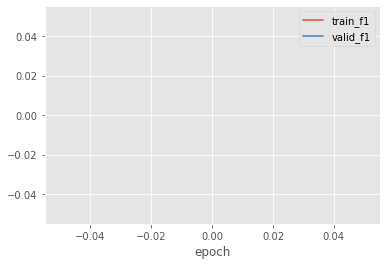

In [27]:
# Plot F1 score with epoch as the x-axis
epoch_f1 = list(epoch_f1_dict.items())
pd.DataFrame({ 'epoch':map(lambda x: x[0] , epoch_f1) , 
              'train_f1':map(lambda x: x[1][0] , epoch_f1), 
              'valid_f1':map(lambda x: x[1][1] , epoch_f1) }) \
    .plot.line(x='epoch')

In [28]:
if CLASSIFIER_USE_BEST:
    object_classifier.load_state_dict(torch.load(os.path.join(HOMEDIR, CLASSIFIER_FILE)))

## Train RNN

In [29]:
epoch_map_dict = {}
best_val_map = 0
            
if TRAIN_RNN:
    for epoch in range(1, RNN_EPOCHS+1):
        
        # Feature extractor and object classifier are put into evaluation mode
        feature_extractor.eval()
        object_classifier.eval()
        
        # Encoder decoder layers are in train mode
        encoder.train()
        decoder.train()
            
        prediction_truths = []
            
        for images, captions in tqdm(data_loader['train'], position=0, leave=True):
            
            # Move batch of images and captions to GPU if CUDA is available
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients
            encoder.zero_grad()
            decoder.zero_grad()
        
            # Pass the images to feature extractor and then object classifier layer
            with torch.no_grad():
                features = feature_extractor(images)
                objects = object_classifier(features) # we use the ground truth classifications to train the RNN
            
            # Get object labels
            #objects = get_objects_labels_from_captions(captions, len(combined_dict)).to(device)
            #objects = torch.Tensor.repeat(objects, repeats=(1, features.size(1))).view(-1, NUM_FRAMES, len(combined_dict))

            # Get image embeddings
            embeddings = encoder(features)
            
            # Combine classified objects with image embeddings
            objects_and_embeddings = torch.cat((objects, embeddings), dim=2) 
            
            # Pass objects and embeddings to RNN
            outputs = decoder(objects_and_embeddings)

            # Calculate the batch loss
            loss = criterion(outputs.view(-1, len(combined_dict)), captions.view(-1))

            # Backward pass
            loss.backward()

            # Prevent gradient explosion
            #nn.utils.clip_grad_norm_(decoder.parameters(), max_norm = 1)

            # Update the parameters in the optimizer
            encoder_decoder_optimizer.step()
            
            # Save outputs and truth labels for map score computation later
            for i in range(outputs.size(0)): # 0,1,...,BATCH_SIZE-1
                top5 = get_top5_predictions_from_output_probabilities(outputs.cpu(), i)
                for j in range(top5.shape[0]): # 0,1,2
                    prediction_truths.append((' '.join(map(lambda x: str(x), list(top5[j]))), str(captions[i,j+1].cpu().numpy())))


        df_temp = pd.DataFrame({ 'label': map(lambda e: e[0], prediction_truths), 'truth_label': map(lambda e: e[1], prediction_truths) })
        
        epoch_map_dict[epoch] = (get_map(df_temp), \
                                  get_map(get_all_predictions('valid')))

        # Save the weights only if the validation performance has improved
        if epoch_map_dict[epoch][1] >= best_val_map:
            best_val_map = epoch_map_dict[epoch][1]
            torch.save(encoder.state_dict(), os.path.join(HOMEDIR, ENCODER_FILE))
            torch.save(decoder.state_dict(), os.path.join(HOMEDIR, DECODER_FILE))
        
        print(f'Epoch {epoch}/{RNN_EPOCHS}, ' +
              f'Loss: {loss.item()}, ' +
              f'Train MAP: {epoch_map_dict[epoch][0] if epoch in epoch_map_dict else None}, ' +
              f'Validation MAP: {epoch_map_dict[epoch][1] if epoch in epoch_map_dict else None}')

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1/15, Loss: 3.000265121459961, Train MAP: 0.3210666666666664, Validation MAP: 0.4195454545454545


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2/15, Loss: 2.4057343006134033, Train MAP: 0.5757019607843145, Validation MAP: 0.5557575757575758


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3/15, Loss: 2.208900213241577, Train MAP: 0.6730823529411775, Validation MAP: 0.6063636363636363


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 4/15, Loss: 1.6990948915481567, Train MAP: 0.7467764705882365, Validation MAP: 0.633030303030303


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5/15, Loss: 1.434696078300476, Train MAP: 0.7990117647058833, Validation MAP: 0.6422727272727272


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 6/15, Loss: 0.8121419548988342, Train MAP: 0.8282980392156871, Validation MAP: 0.6542424242424243


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 7/15, Loss: 0.7612224817276001, Train MAP: 0.8585333333333341, Validation MAP: 0.646969696969697


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 8/15, Loss: 0.6618000268936157, Train MAP: 0.8869098039215693, Validation MAP: 0.6683333333333333


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9/15, Loss: 0.7457534670829773, Train MAP: 0.906517647058824, Validation MAP: 0.6224242424242424


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10/15, Loss: 0.35167133808135986, Train MAP: 0.9309411764705885, Validation MAP: 0.6515151515151515


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 11/15, Loss: 0.42597347497940063, Train MAP: 0.942156862745098, Validation MAP: 0.6539393939393939


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12/15, Loss: 0.2955680787563324, Train MAP: 0.9521647058823529, Validation MAP: 0.6553030303030303


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 13/15, Loss: 0.3114777207374573, Train MAP: 0.9658509803921566, Validation MAP: 0.6513636363636364


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14/15, Loss: 0.2477155327796936, Train MAP: 0.9618352941176471, Validation MAP: 0.6536363636363637


100%|██████████| 43/43 [01:50<00:00,  2.57s/it]


Epoch 15/15, Loss: 0.5077780485153198, Train MAP: 0.9101333333333336, Validation MAP: 0.6387878787878787


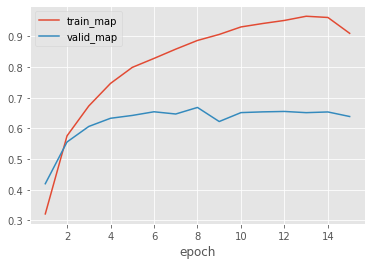

In [30]:
# Plot MAP score with epoch as the x-axis
epoch_map = list(epoch_map_dict.items())
pd.DataFrame({ 'epoch':map(lambda x: x[0] , epoch_map) , 
              'train_map':map(lambda x: x[1][0] , epoch_map), 
              'valid_map':map(lambda x: x[1][1] , epoch_map) }) \
    .plot.line(x='epoch')

In [31]:
if RNN_USE_BEST:
    encoder.load_state_dict(torch.load(os.path.join(HOMEDIR, ENCODER_FILE)))
    decoder.load_state_dict(torch.load(os.path.join(HOMEDIR, DECODER_FILE)))

## Validation

In [32]:
images, _ = next(iter(data_loader['valid']))
predictions = get_predictions(images)
classifications = get_classifications(images)

In [33]:
n = 5
sample_indices = random.sample(range(0, min(BATCH_SIZE, len(val_indices))), min(n, BATCH_SIZE, len(val_indices)))

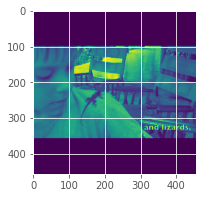

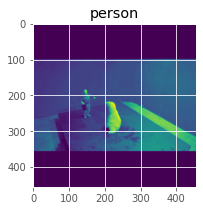

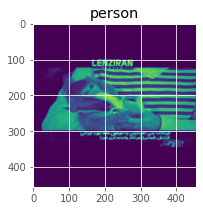

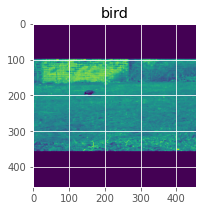

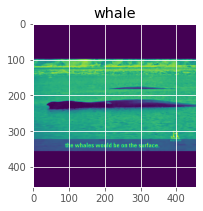

In [34]:
for i in sample_indices:
    show_classifications(images, classifications, i)

In [35]:
for i in sample_indices:
    show_prediction(images, predictions, i)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
# Process all entries in the validation set
validation_results_df = get_all_predictions('valid')
validation_results_df['image_index'] = validation_results_df.image.apply(lambda i: val_indices[i])
validation_results_df.to_csv('validation.csv')
validation_results_df.head(12)

,image,order,prediction_words,truth_words,label,truth_label,image_index
0,0,0,monkey squirrel dog red_panda snake,person,11 18 29 20 24,30,259
1,0,1,sit_next_to sit_right sit_behind walk_right li...,taller,19 74 55 38 3,43,259
2,0,2,monkey person squirrel red_panda hamster,monkey,11 30 18 20 16,11,259
3,1,0,giant_panda lion red_panda bear bird,giant_panda,13 3 20 21 15,13,313
4,1,1,sit_right walk_right stand_front lie_front wal...,stand_right,74 38 42 64 39,63,313
5,1,2,giant_panda person red_panda bear turtle,giant_panda,13 30 20 21 0,13,313
6,2,0,bicycle turtle horse bear dog,bear,2 0 9 21 29,21,299
7,2,1,walk_front walk_right stand_behind stand_right...,stand_right,65 38 47 63 15,63,299
8,2,2,person turtle giant_panda bear snake,person,30 0 13 21 24,30,299
9,3,0,bear dog turtle snake lion,bear,21 29 0 24 3,21,125


In [37]:
print('Your validation MAP score is:', get_map(validation_results_df))

Your validation MAP score is: 0.6683333333333333


## Test

In [38]:
# Process all entries in the test set
test_results_df = get_all_predictions('test')
test_results_df.head(12)

,image,order,prediction_words,truth_words,label,truth_label
0,0,0,dog fox turtle horse monkey,None,29 12 0 9 11,
1,0,1,walk_front stand_behind bite run_front stand_left,None,65 47 28 8 75,
2,0,2,frisbee dog car fox person,None,4 29 33 12 30,
3,1,0,dog monkey turtle horse snake,None,29 11 0 9 24,
4,1,1,walk_front run_front run_right stand_behind bite,None,65 8 70 47 28,
5,1,2,dog frisbee person monkey turtle,None,29 4 30 11 0,
6,2,0,bicycle motorcycle sheep train lizard,None,2 5 8 23 31,
7,2,1,move_beneath stand_right walk_behind lie_right...,None,24 63 17 50 16,
8,2,2,person sheep watercraft bird airplane,None,30 8 10 15 7,
9,3,0,bicycle motorcycle dog person horse,None,2 5 29 30 9,


In [39]:
# Write results as csv
test_results_df.to_csv(f'valmap{get_map(validation_results_df)}_{OUTPUT_FILENAME}', index=True, header=True, index_label='Id', columns=['label'])